# Visualize L1 and L2 regularization

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from mpl_toolkits.mplot3d import Axes3D # required even though not ref'd!
import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'

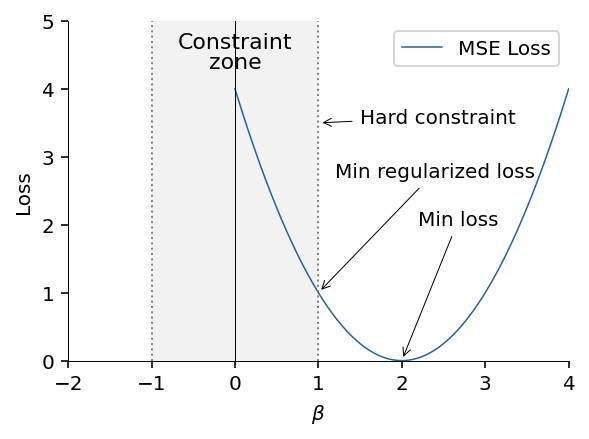

In [2]:
def loss(x,y,b):
    losses = []
    for b_ in b:
        losses.append( np.sum((y - (0 + b_*x))**2) )
    return np.array(losses)

lmbda=1.0
penalty='l1'
yrange=(0,5)
mse_color = '#225ea8'
reg_color = '#fdae61'
sum_color = '#41b6c4'
fig, ax = plt.subplots(1,1,figsize=(4.2,3.2))

x = np.linspace(0,5,6)
x = (x - np.mean(x)) / np.std(x)  # normalize x
y = 2 * x

b1 = np.linspace(0,4,1000)    
mse = (b1-2)**2
#     mse = loss(x,y,b=b1)
if penalty=='l1':
    reg = lmbda * np.abs(b1)
else:
    reg = lmbda * b1**2

if yrange is None:
    yrange = (0, max(mse))

min_mse = np.min(mse)
min_mse_x = 2#b1[np.argmin(mse)]
min_loss = np.min(mse+reg)
min_loss_x = b1[np.argmin(mse+reg)]
#     print(np.where(np.abs(mse-reg)<.01), b1[np.where(np.abs(mse-reg)<.01)])
#    print(np.where(mse==reg))#, b1[np.argmin(mse-reg)])
ax.plot(b1, mse, lw=.75, c=mse_color, label="MSE Loss")#label="MSE Loss = $\Sigma(y-\\hat{y})^2$")
# verticle bar
ax.plot([lmbda,lmbda], [0,yrange[1]], ':', lw=1,c='grey')
ax.plot([-lmbda,-lmbda], [0,yrange[1]], ':', lw=1,c='grey')
ax.plot([0,0], [0,yrange[1]*1.1], lw=.5, c='k')
safe = plt.Rectangle((0,0), lmbda, yrange[1], facecolor="grey", alpha=0.1)
ax.add_patch(safe)
safe = plt.Rectangle((0,0), -lmbda, yrange[1], facecolor="grey", alpha=0.1)
ax.add_patch(safe)

#ax.text(.5,5.4, "$\lambda$", fontsize=15, horizontalalignment='center')
ax.text(0,4.6, 'Constraint', fontsize=11, horizontalalignment='center')
ax.text(0,4.3, 'zone', fontsize=11, horizontalalignment='center')
ax.annotate("Hard constraint",(1.0,3.5),xytext=(1.5,3.5),arrowprops=dict(arrowstyle="->",linewidth=.5))
ax.annotate("Min loss",(2,0),xytext=(2.2,2),arrowprops=dict(arrowstyle="->",linewidth=.5))
ax.annotate("Min regularized loss",(1.0,1.0),xytext=(1.2,2.7),arrowprops=dict(arrowstyle="->",linewidth=.5))
ax.set_xlabel("$\\beta$")
ax.set_ylabel("Loss")
ax.set_ylim(*yrange)
ax.legend(loc='upper right')
ax.set_xlim(-2,4.0)

ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("reg1D.svg", bbox_inches=0, pad_inches=0)
plt.show()

## L2

In [15]:
def plot_reg(penalty:('l1','l2')='l2',lmbda:float=1.0,show_reg=True,
             xrange=None,yrange=None,fill=True,
             dpi=200):
    def loss(x,y,b):
        losses = []
        for b_ in b:
            losses.append( np.sum((y - (0 + b_*x))**2) )
        return np.array(losses)
    
    mse_color = '#225ea8'
    reg_color = '#fdae61'
    sum_color = '#41b6c4'
    fig, ax = plt.subplots(1,1)
    
    # get x,y as line with slope beta = 2 + noise
    x = np.linspace(0,5,6)
    x = (x - np.mean(x)) / np.std(x)  # normalize x
    y = 2 * x# + np.random.uniform(0,1,size=len(x))
    
#     lm = LinearRegression()
#     lm.fit(x.reshape(-1,1),y)
#     print(f"Slope of data is {lm.coef_[0]}")
    
    b1 = np.linspace(0,4,1000)    
    mse = (b1-2)**2
#     mse = loss(x,y,b=b1)
    if penalty=='l1':
        reg = lmbda * np.abs(b1)
    else:
        reg = lmbda * b1**2

    if yrange is None:
        yrange = (0, max(mse))

#     print(lmbda)
#     print("b1 cross", mse / lmbda, "len mse", len(mse))
#     print("b1 cross", mse)
#     print("b1 cross no lmbda", b1[np.argmin(mse)])
    
    min_mse = np.min(mse)
    min_mse_x = 2#b1[np.argmin(mse)]
    min_loss = np.min(mse+reg)
    min_loss_x = b1[np.argmin(mse+reg)]
#     print(np.where(np.abs(mse-reg)<.01), b1[np.where(np.abs(mse-reg)<.01)])
#    print(np.where(mse==reg))#, b1[np.argmin(mse-reg)])
    ax.plot(b1, mse, lw=.75, label="$\Sigma(y-\\hat{y})^2$", c=mse_color)
    if show_reg:
        reg_label = "$\\lambda |\\beta_1|$" if penalty=='l1' else "$\\lambda \\beta_1^2$"
        ax.plot(b1, reg, lw=.3, label=reg_label, c=reg_color)
        ax.plot(b1, mse + reg, '--', lw=1, label="$(y-\\hat{y})^2$ + "+reg_label, c=sum_color)
        ax.annotate("Min mse+reg",(min_loss_x,min_loss),xytext=(min_loss_x,min_loss*1.2),
                    arrowprops=dict(arrowstyle="->"), horizontalalignment='right')
        # vertible bar
        ax.plot([min_loss_x,min_loss_x], [0,yrange[1]],lw=.5,c='grey')
        if fill:
            ax.fill_between(b1, reg, 0, color=reg_color, alpha=.15)
        delta_x = min_loss_x-min_mse_x
        delta_midpoint_x = (min_mse_x+min_loss_x)/2
        ax.text(delta_midpoint_x,yrange[1]-yrange[1]*.1,f"$\\lambda={lmbda:.2f}$ ({penalty.upper()})",
               horizontalalignment='center')
        ax.text(delta_midpoint_x,yrange[1]-yrange[1]*.15,f"$\\Delta_{{\\beta}}$={delta_x:.1f}",
               horizontalalignment='center')
#         ax.text(2,15,f"shifts min loss",
#                horizontalalignment='center')
        if not np.isclose(min_loss_x,min_mse_x):
            ax.arrow(min_mse_x, yrange[1]-yrange[1]*.03, (min_loss_x-min_mse_x), 0, lw=.5, 
                    head_length=0.05,
                    head_width=0.2,
                    length_includes_head=True)
    # verticle bar
    ax.plot([min_mse_x,min_mse_x], [0,yrange[1]],lw=.5,c='grey')
    ax.annotate("Min mse",(2,0),xytext=(2.2,2),arrowprops=dict(arrowstyle="->"))
    ax.set_xlabel("$\\beta_1$")
    ax.set_ylabel("Loss")
    if xrange is not None:
        ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.legend(loc='upper right')

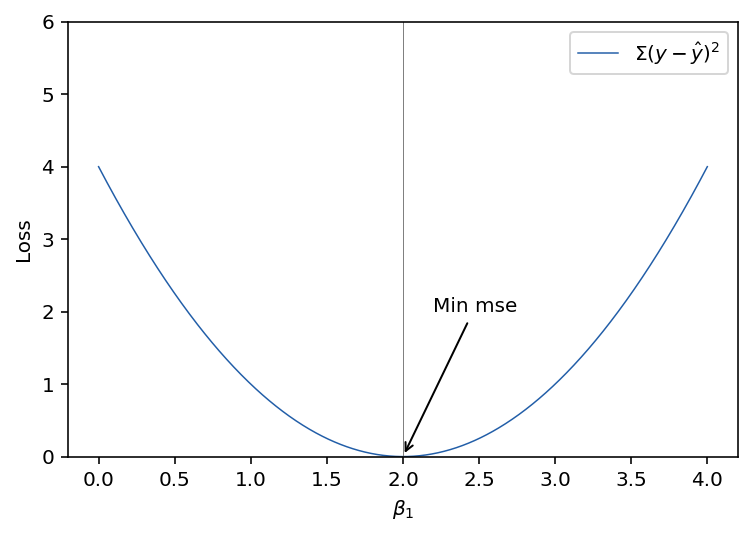

In [16]:
plot_reg('l2',show_reg=False, yrange=(0,6))

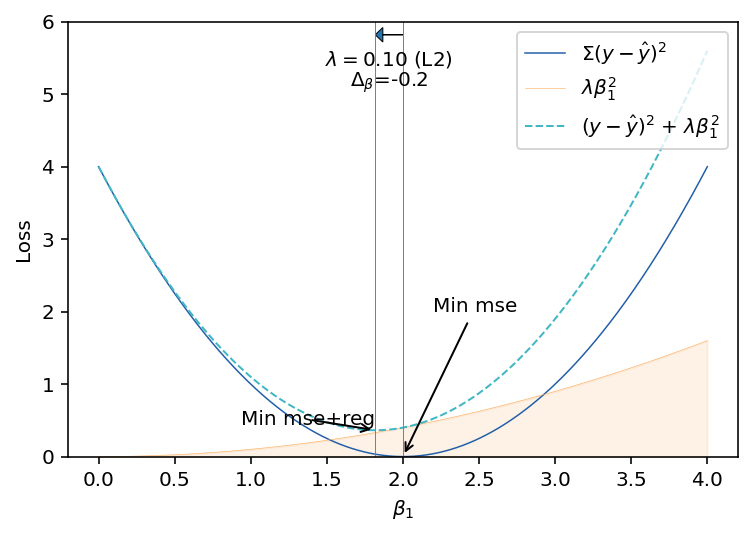

In [5]:
plot_reg('l2',lmbda=.1,yrange=(0,6))

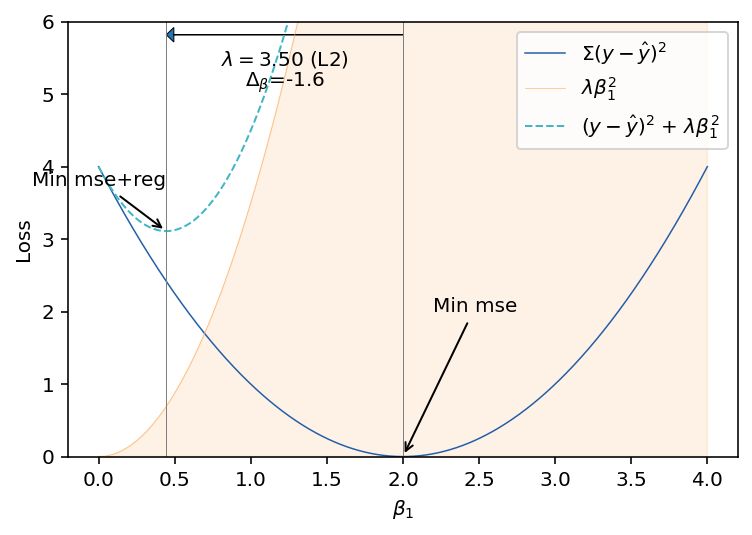

In [6]:
plot_reg('l2',lmbda=3.5, yrange=(0,6))

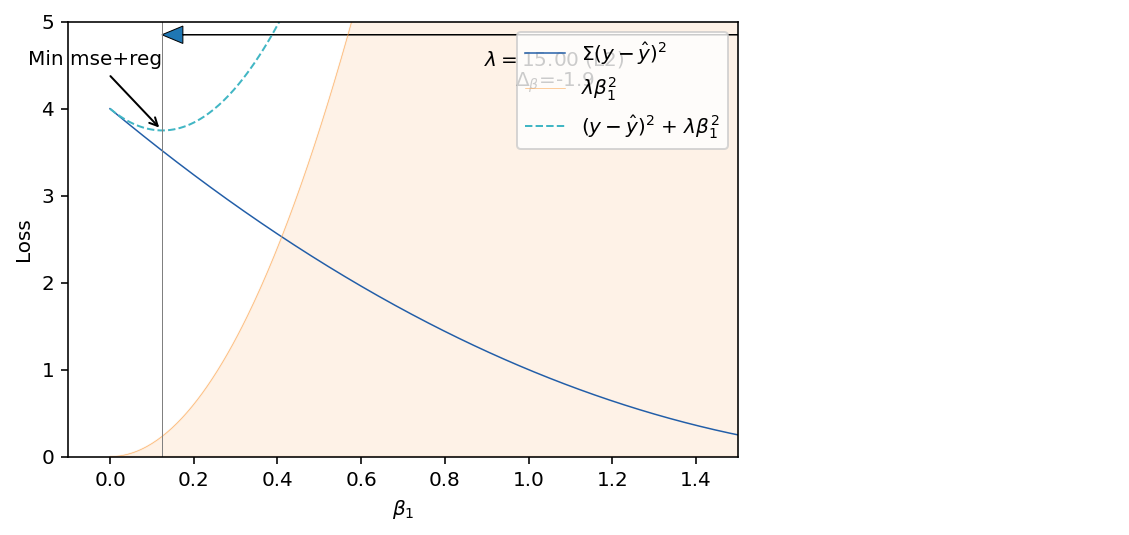

In [7]:
plot_reg('l2',lmbda=15, xrange=(-.1,1.5), yrange=(0,5)) # zoom in

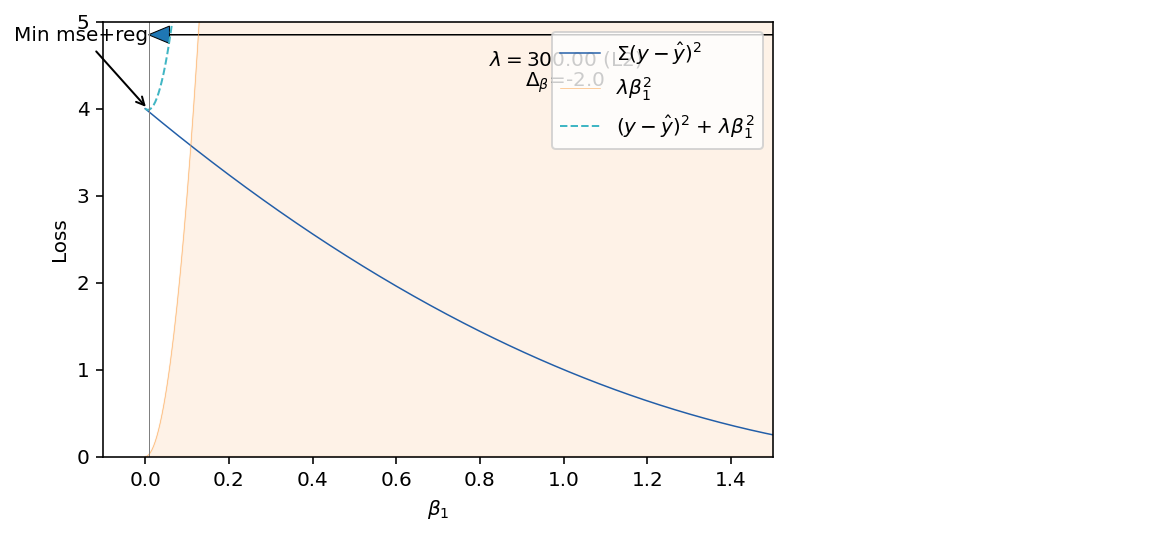

In [8]:
plot_reg('l2',lmbda=300, xrange=(-.1,1.5), yrange=(0,5)) # zoom in

## L1

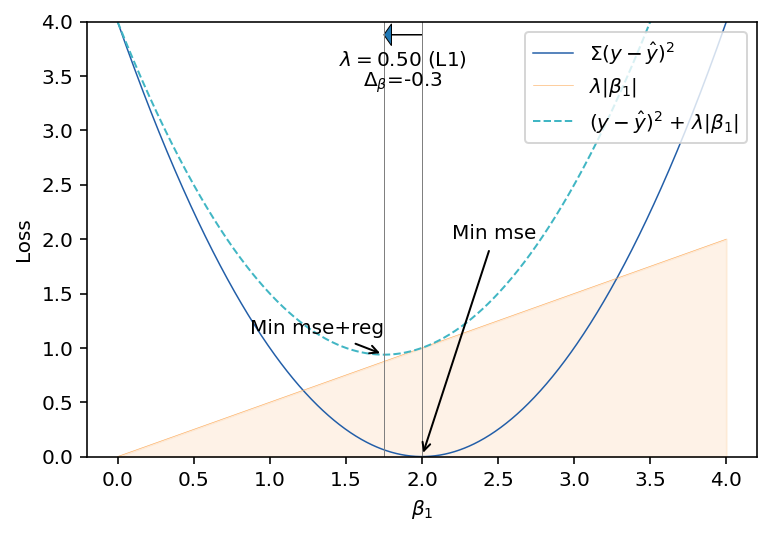

In [9]:
plot_reg('l1',lmbda=.5)

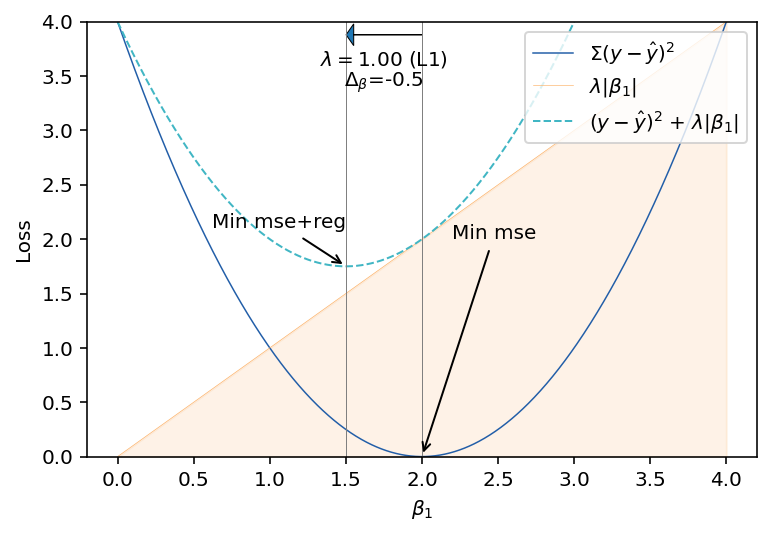

In [10]:
plot_reg('l1',lmbda=1)

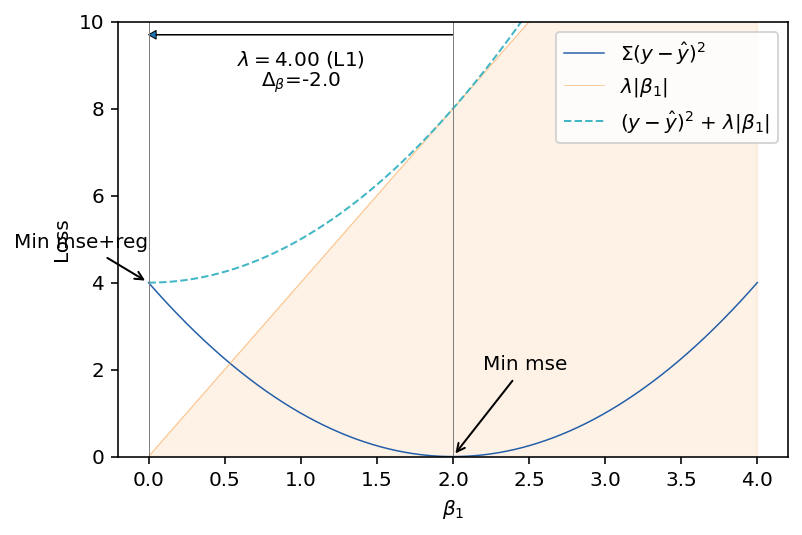

In [11]:
plot_reg('l1',lmbda=4, yrange=(0,10))

## Animate

In [17]:
import glob
import os
from PIL import Image as PIL_Image

def animate(penalty, lrange, step, yrange, dpi=100, duration=80):
    plt.close()
    for f in glob.glob(f'/tmp/{penalty}-frame-*.png'):
        os.remove(f)

    for lmbda in np.arange(*lrange,step):
        plot_reg(penalty,lmbda=lmbda,fill=False,yrange=yrange)
#         print(f"/tmp/{penalty}-frame-{lmbda:06.3f}.png")
        plt.savefig(f"/tmp/{penalty}-frame-{lmbda:06.3f}.png", bbox_inches=0, pad_inches=0, dpi=dpi)
        plt.close()

    images = [PIL_Image.open(image) for image in sorted(glob.glob(f'/tmp/{penalty}-frame-*.png'))]
    images += reversed(images)
    images[0].save(f'/tmp/{penalty}-animation.gif',
                   save_all=True,
                   append_images=images[1:],
                   duration=duration,
                   loop=0)

In [20]:
animate('l1',lrange=(0.0,5), step=.2, yrange=(0,6), dpi=200)

In [21]:
animate('l2',lrange=(0.0,11), step=.3, yrange=(0,6), dpi=200, duration=100)